In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from faces_clustering import Clusterer, is_image, get_files_folder

Using TensorFlow backend.


In [2]:
import random
random.seed(42)

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
backbones = ['resnet50','senet50','vgg16']

# Checking Classes

In [15]:
df_embs = pd.read_pickle(f'../data/leg55_{backbones[1]}.pkl')

In [18]:
len(df_embs.urls.unique())

9006

In [ ]:
df_embs['classes'] = df_embs.urls.apply(lambda x: x.split('\\')[-2])

In [ ]:
df_embs.to_pickle(f'../data/leg55_{backbones[2]}.pkl')

# DataSeparation

In [21]:
df_embs = pd.read_pickle(f'../data/leg55_{backbones[0]}.pkl')

In [22]:
test_index = df_embs.sample(frac=1, random_state=42).groupby('classes').head(1).sort_values('classes').index

In [23]:
test_index

Int64Index([   8,   14,   37,   50,   76,   80,  101,  107,  131,  149,
            ...
            8804, 8826, 8839, 8866, 8870, 8889, 8925, 8946, 8973, 9004],
           dtype='int64', length=513)

In [25]:
for backbone in backbones:
    df_backbone = pd.read_pickle(f'../data/leg55_{backbone}.pkl')
    df_test = df_backbone.loc[test_index].copy()
    df_train = df_backbone.loc[df_embs.index.difference(test_index)].copy()
    print(f"{backbone} {len(df_backbone.urls.unique())}: Train: {len(df_train.urls.unique())} Test:{len(df_test.urls.unique())}")
    #df_train.to_pickle(f'../data/train_leg55_{backbone}.pkl')
    #df_test.to_pickle(f'../data/test_leg55_{backbone}.pkl')

resnet50 9006: Train: 8493 Test:513
senet50 9006: Train: 8493 Test:513
vgg16 9006: Train: 8493 Test:513


# Clustering Train

In [ ]:
all_clusters = {}
for backbone in backbones:
    df_train = pd.read_pickle(f'../data/train_leg55_{backbone}.pkl')
    clusterer = Clusterer(n_clusters=513, face_embeddings = df_train,algs=[
        'kmeans', 'affinity', 'agglomerative'])
    clusters, models_inst = clusterer.clusterize(normalize=False)
    
    all_clusters[backbone] = clusters

In [33]:
dt_clusters = pd.concat(all_clusters.values(), keys = all_clusters.keys())

In [ ]:
dt_clusters.to_pickle('../data/clusters_train_leg55.pkl')

In [39]:
dt_clusters = pd.read_pickle('../data/clusters_train_leg55.pkl')

In [40]:
print(f"Train Size: {len(dt_clusters.loc['senet50'].urls.unique())}")

Train Size: 8490


## Evaluating Train

In [35]:
from sklearn import metrics

In [37]:
df_all = {}
for backbone in ['resnet50']:
    clusters = dt_clusters.loc[backbone]
    
    cluster_cols = [c for c in clusters.columns if str(c).startswith('cluster')]
    labels_true = clusters.classes.values
    
    dict_results = {}
    for col in cluster_cols:
        labels_pred = clusters[col].values

        dict_results[col] = [metrics.homogeneity_score(labels_true,labels_pred),
                            metrics.completeness_score(labels_true, labels_pred),
                            metrics.v_measure_score(labels_true, labels_pred)]
    df_all[backbone] = pd.DataFrame.from_dict(dict_results, orient='index', columns=[
        'Homogeneity Score', 'Completeness Score', 'V-Measure'])
    
df_all_results = pd.concat(df_all.values(), keys=df_all.keys())
    

In [38]:
df_all_results

Homogeneity Score  Completeness Score  \
resnet50 cluster_kmeans                   0.96652             0.96752   
         cluster_affinity                 0.00000             1.00000   
         cluster_agglomerative            0.98215             0.97979   

                                V-Measure  
resnet50 cluster_kmeans           0.96702  
         cluster_affinity         0.00000  
         cluster_agglomerative    0.98096

In [ ]:
df_all_results.to_csv('../results/train_clusters.csv')

# Test

In [6]:
cluster_alg = 'cluster_agglomerative'

In [7]:
from faces_clustering import FaceSearcher
backbone = backbones[1]

In [8]:
df_embs = pd.read_pickle('../data/clusters_train_leg55.pkl').loc[backbone]

In [9]:
from sklearn.metrics import silhouette_samples
embs_list = list(df_embs.embeddings.apply(list).values)
silhouette = silhouette_samples(embs_list, df_embs.cluster_agglomerative.values)
df_embs['silhouette'] = silhouette
df_embs_silhouette = df_embs.loc[df_embs.groupby('cluster_agglomerative')['silhouette'].idxmax().values]

In [10]:
print(backbone, df_embs_silhouette.shape)
df_embs_silhouette.head()

senet50 (513, 7)


,urls,embeddings,classes,cluster_kmeans,cluster_affinity,cluster_agglomerative,silhouette
3549,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.06293261, 0.041238066, 1.0586125, 1.9255624...",178836_p,304,258,0,0.34280
6347,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.09170138, 5.6202917, 0.012911335, 0.0005637...",202063_p,369,466,1,0.23108
5007,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[1.1189567, 0.008136402, 2.7333353, 1.4765488,...",178925_p,367,364,2,0.15233
104,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.045791216, 8.492915, 0.032269478, 0.0003377...",129037_b,444,8,3,0.00429
2540,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[2.8295155, 0.32453766, 1.1752279, 6.7835546, ...",160630_p,176,187,4,0.30576


In [11]:
searcher = FaceSearcher(face_embs = df_embs_silhouette, classes_col = cluster_alg)

In [12]:
df_test = pd.read_pickle('../data/test_leg55_senet50.pkl')

In [13]:
df_test[['urls','classes']].loc[df_test['classes'] == '73674_b'].urls.values

array(['C:/Users/paulo/Documents/FacesProject/slnp_faces_leg_55\\73674_b\\13_0.jpg'],
      dtype=object)

In [14]:
print(f"Test size is {df_test.shape[0]}")

Test size is 513


In [15]:
embs_query = [l.tolist() for l in df_test.embeddings.values]

In [16]:
_, results = searcher.closest_centroids(embs_query = embs_query)

In [17]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))

In [18]:
def m1(x, k):
    m1 = softmax((1/x).nlargest(k)).head(1)
    return (m1.index.values[0],m1.values[0])

In [19]:
pcts = [m1(r,5)[1] for r in results]

In [20]:
np.mean(np.array(pcts)>=0.5)

0.7290448343079922

In [21]:
np.mean(np.array(pcts))

0.6800747566460049

In [22]:
import matplotlib.pyplot as plt

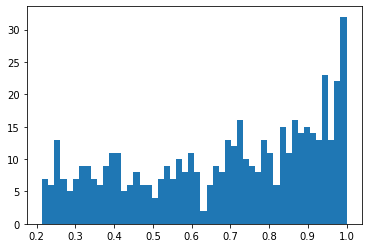

In [23]:
_ = plt.hist(pcts, bins=50)

In [24]:
df_test['results'] = results

In [25]:
mode_clusters = df_embs.groupby(cluster_alg)['classes'].apply(lambda x: x.value_counts(dropna=False).idxmax())

In [26]:
classes_by_cluster = df_embs.groupby(cluster_alg)['classes'].apply(set)

In [27]:
any_k = []
mode_k = []
has_class_k = []

for k in range(2,11):
    p_clusters = df_test['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    any_k.append(np.mean(p_clusters != -1))
    #print(f"{k}: Assigned to any: {any_k[-1]}")
    mode_k.append((df_test.classes == p_clusters.map(mode_clusters)).mean())
    #print(f"{k}: Assigned to cluster of mode: {mode_k[-1]}")
    
    comp = []
    for myclass, classes in zip(df_test.classes,p_clusters.map(classes_by_cluster)):
        comp.append(classes == classes and myclass in classes)
    has_class_k.append(np.mean(comp))    
    #print(f"{k}: Assigned to cluster with class in the cluster {has_class_k[-1]}")

In [28]:
df_results = pd.DataFrame(np.transpose([any_k, mode_k, has_class_k]),
             index = range(2,11), columns=['Any_Cluster', 'Mode Equal to Class', 'Class is present in cluster'])
df_results

,Any_Cluster,Mode Equal to Class,Class is present in cluster
2,1.00000,0.93177,0.94347
3,0.86355,0.85575,0.86160
4,0.76998,0.76608,0.76998
5,0.72904,0.72515,0.72904
6,0.68811,0.68421,0.68811
7,0.64912,0.64522,0.64912
8,0.61209,0.60819,0.61209
9,0.60039,0.59649,0.60039
10,0.58285,0.57895,0.58285


## How many are necessary to achieve 100%?

In [269]:
len(set(mode_clusters.values))

496

In [270]:
def closest_clusters(x, k):
    return (1/x).nlargest(k).index.values

In [271]:
df_closest = df_test[['urls', 'classes']].copy()
df_closest.head(2)

,urls,classes
8,C:/Users/paulo/Documents/FacesProject/slnp_fac...,105112_b
14,C:/Users/paulo/Documents/FacesProject/slnp_fac...,112437_b


In [272]:
df_closest['closest_clusters'] = df_test['results'].apply(lambda x: closest_clusters(x, 513))
df_closest.head(2)

,urls,classes,closest_clusters
8,C:/Users/paulo/Documents/FacesProject/slnp_fac...,105112_b,"[422, 0, 43, 85, 113, 191, 95, 31, 294, 152, 2..."
14,C:/Users/paulo/Documents/FacesProject/slnp_fac...,112437_b,"[354, 274, 57, 75, 97, 64, 263, 22, 164, 235, ..."


In [273]:
classes_closest_clusters = df_closest['closest_clusters'].apply(pd.Series).apply(
    lambda x: x.map(classes_by_cluster))

In [274]:
classes_closest_clusters.head(2)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
8,"{132504_b, 105112_b}",{178836_p},{160976_p},{74571_b},{178909_p},"{73483_b, 166401_p}",{160518_p},"{160512_p, 74585_b, 178863_p, 160672_p, 178802_p}",{178950_p},{178982_p},...,{178858_p},{141431_b},{178981_p},{74319_b},{162332_p},{141391_b},{74351_b},{178892_p},{73466_b},{160649_p}
14,{112437_b},{151208_p},"{72912_b, 178853_p, 74371_b, 178846_p, 160578_...",{160604_p},"{74398_b, 74784_b, 178901_p, 112437_b, 178949_...",{148134_p},{178947_p},{178904_p},{178849_p},{74372_b},...,{74177_b},{74460_b},{178892_p},{160535_p},{178941_p},{73692_b},{178981_p},{73466_b},{141542_p},{160510_p}


In [275]:
classes_closest_clusters.shape[1]

513

In [276]:
first_cluster = []
for (_,face_class),(_,cluster_classes) in zip(df_closest.iterrows(), classes_closest_clusters.iterrows()):
    present_cluster = cluster_classes.apply(lambda x: (face_class.classes in list(x)))
    for i, cluster in enumerate(present_cluster):
        if cluster:
            first_cluster.append(i+1)
            break

In [277]:
df_closest['first_returned_present'] = first_cluster

In [279]:
pcts_n_returned = []
last_pct = -1
for i in range(1,513):
    pct = (df_closest.first_returned_present<=i).mean()
    
    if pct!=last_pct:
        pcts_n_returned.append((i,pct))
        last_pct = pct
pcts_n_returned

[(1, 0.9824561403508771),
 (2, 0.9844054580896686),
 (3, 0.98635477582846),
 (7, 0.9902534113060428),
 (10, 0.9922027290448343),
 (11, 0.9941520467836257),
 (23, 0.9961013645224172),
 (37, 0.9980506822612085),
 (218, 1.0)]

## Checking wrong classes

In [280]:
p_clusters = df_test['results'].apply(lambda x: m1(x,2)[0] if m1(x,2)[1] >= 0.5 else -1)

In [281]:
classes_wrong = df_test.loc[df_test.classes != p_clusters.map(mode_clusters)].classes

In [282]:
classes_right = df_test.loc[df_test.classes == p_clusters.map(mode_clusters)].classes

In [283]:
classes_count = df_embs.groupby('classes')['urls'].count()

In [284]:
classes_count.loc[classes_count<=5].count()

23

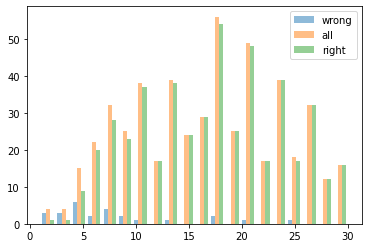

In [285]:
import matplotlib.pyplot as plt

_ = plt.hist([classes_wrong.map(classes_count), classes_count, classes_right.map(classes_count)], 
    density=False, bins=20, alpha=0.5, label=['wrong', 'all', 'right'])
_ = plt.legend()
#_ = plt.hist(, density=True, bins=12, alpha=0.5,label = 'class dist')

In [286]:
def fxs(x):
    if x < 6:
        return '1-5'
    if x < 11:
        return '6-10'
    if x < 16:
        return '11-15'
    if x < 21:
        return '16-20'
    if x < 26:
        return '21-25'
    return '26-30'

In [287]:
df_fxs_count = pd.concat([classes_wrong.map(classes_count).apply(fxs).value_counts(),
            classes_right.map(classes_count).apply(fxs).value_counts()], axis=1).reindex(
    ['1-5','6-10','11-15','16-20','21-25','26-30'])
df_fxs_count

,classes,classes
1-5,12.00000,11
6-10,8.00000,87
11-15,2.00000,100
16-20,3.00000,135
21-25,1.00000,94
26-30,nan,60


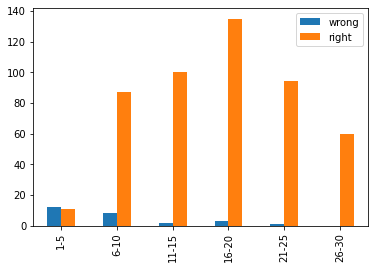

In [288]:
df_fxs_count.columns = ['wrong','right']
df_fxs_count.plot.bar()

# LFW

In [29]:
from faces_clustering import FeatureExtractor

In [33]:
path = '/home/paulo/Documentos/0_LFW_dataset'

In [34]:
lfw = get_files_folder(path, criteria=is_image)

In [35]:
sample = random.sample(lfw, 513)

In [36]:
df_lfw = FeatureExtractor('senet50').extract(sample)


,urls,embeddings
0,/home/paulo/Documentos/0_LFW_dataset/Kim_Dae-j...,"[0.48840332, 0.144612, 0.0148019, 0.05020816, ..."
1,/home/paulo/Documentos/0_LFW_dataset/Hans_Blix...,"[1.6899444, 0.052105, 0.20930415, 0.47116968, ..."
2,/home/paulo/Documentos/0_LFW_dataset/Pete_Samp...,"[0.047221407, 1.1174889, 0.0030544905, 0.27338..."


In [37]:
lfw_query = [l.tolist() for l in df_lfw.embeddings.values]

In [38]:
_, results_lfw = searcher.closest_centroids(embs_query = lfw_query)

In [39]:
df_lfw['results'] = results_lfw

In [40]:
lfw = []
for k in range(2,11):
    lfw_clusters = df_lfw['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    print(f"k: {k} {np.mean(lfw_clusters==-1)}")
    lfw.append(np.mean(lfw_clusters==-1))

k: 2 0.0
k: 3 0.9824561403508771
k: 4 0.9941520467836257
k: 5 0.9980506822612085
k: 6 1.0
k: 7 1.0
k: 8 1.0
k: 9 1.0
k: 10 1.0


In [ ]:
df_results = pd.read_csv('../results/test_clusters.csv', index_col=0)

In [41]:
df_results.index.name='alpha'
df_results['lfw assigned to no cluster'] = lfw

In [42]:
#df_results.apply(lambda x: x.apply(lambda y: f'{y*100:.4f} %'))
df_results

,Any_Cluster,Mode Equal to Class,Class is present in cluster,lfw assigned to no cluster
alpha,,,,
2,1.00000,0.93177,0.94347,0.00000
3,0.86355,0.85575,0.86160,0.98246
4,0.76998,0.76608,0.76998,0.99415
5,0.72904,0.72515,0.72904,0.99805
6,0.68811,0.68421,0.68811,1.00000
7,0.64912,0.64522,0.64912,1.00000
8,0.61209,0.60819,0.61209,1.00000
9,0.60039,0.59649,0.60039,1.00000
10,0.58285,0.57895,0.58285,1.00000


In [43]:
df_results.to_csv('../results/test_clusters_silhouette.csv')